In [1]:
cd ..

/home/max/Documents/mgr


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics
from sklearn.decomposition import PCA
from tqdm import tqdm

from src.simplefact import *
from src.simplefact.syntax import *
from src.reasoner import *
from src.generate import *
from src.utils import *
from src.vis import *

seed = 2022

In [3]:
onto = load_ofn('local/out/dataset/pizza.ofn', silent=True)
fact = Reasoner.from_onto(onto, timeout=10_000)
onto.use_annotations_as_names()
onto.use_prefix('pizza:')
C = onto.concept_by_name
R = onto.role_by_name
onto

<Onto 99 concepts, 4 roles, 287 axioms>

In [4]:
rng = np.random.default_rng(seed)
Nc = onto.n_concepts
Nr = onto.n_roles
gen = AxiomGenerator(rng=rng, n_concepts=Nc, n_roles=Nr, max_depth=4, p_atomic=0.95)
        
n_queries = 32_000
queries, answers, qset = [], [], set()
while len(queries) < n_queries:
    axiom = gen()
    axiom_core = core(axiom)
    if axiom_core in qset: continue
    answer = fact.check_axiom(axiom)
    queries.append(axiom_core); answers.append(float(answer)); qset.add(axiom_core)
    
print(onto.render(queries[100]))
print(len(answers))
print(np.round(np.mean(answers), 4))

LeekTopping ⊑ SpicyPizzaEquivalent
32000
0.411


In [5]:
X_te = [core(x) for x in queries]
y_te = answers
idx_te = [0]*len(X_te)
data = idx_te, X_te, y_te

rng = np.random.default_rng(seed)

params = dict(emb_size=10, hidden_size=16, onto=onto)

T.manual_seed(seed)
unfrozen_r = NeuralReasoner(**params)

T.manual_seed(seed)
transfer_r = NeuralReasoner(**params)
transfer_r.head.load_state_dict(T.load('local/out/exp/20220715T194304/reasoner.pt'))

T.manual_seed(seed)
random_r = NeuralReasoner(**params)

params = dict(epoch_count=30, batch_size=32, lr_reasoner=0.001, lr_encoder=0.001)

print('unfrozen reasoner head')
T.manual_seed(seed)
unfrozen_log = train(data, None, unfrozen_r.head, [unfrozen_r.embs], run_name='unfrozen', **params)

print('----')

print('frozen reasoner head (transfer)')
T.manual_seed(seed)
transfer_log = train(data, None, transfer_r.head, [transfer_r.embs], freeze_reasoner=True, run_name='frozen transfer', **params)

print('----')

print('frozen reasoner head (random)')
T.manual_seed(seed)
random_log = train(data, None, random_r.head, [random_r.embs], freeze_reasoner=True, run_name='frozen random', **params)

unfrozen reasoner head
train epoch 00/30 | batch 1001/1000 | loss 0.7194 | val loss 0.7194 | acc 0.4110 | f1 0.5826 | prec 0.4110 | recall 1.0000 | roc auc 0.7239 | pr auc 0.5870 | elapsed 9.13s
train epoch 01/30 | batch 1001/1000 | loss 0.3335 | val loss 0.2053 | acc 0.9222 | f1 0.9047 | prec 0.9106 | recall 0.8988 | roc auc 0.9727 | pr auc 0.9631 | elapsed 15.95s
train epoch 02/30 | batch 1001/1000 | loss 0.1932 | val loss 0.1695 | acc 0.9351 | f1 0.9217 | prec 0.9140 | recall 0.9295 | roc auc 0.9811 | pr auc 0.9736 | elapsed 16.08s
train epoch 03/30 | batch 1001/1000 | loss 0.1588 | val loss 0.1280 | acc 0.9557 | f1 0.9462 | prec 0.9439 | recall 0.9485 | roc auc 0.9884 | pr auc 0.9838 | elapsed 15.79s
train epoch 04/30 | batch 1001/1000 | loss 0.1199 | val loss 0.0967 | acc 0.9688 | f1 0.9620 | prec 0.9638 | recall 0.9601 | roc auc 0.9927 | pr auc 0.9902 | elapsed 15.76s
train epoch 05/30 | batch 1001/1000 | loss 0.0962 | val loss 0.0815 | acc 0.9742 | f1 0.9684 | prec 0.9744 | reca

------
Unfrozen reasoner head
train time 380.46209812164307
             mean  std     micro
acc      0.993031  NaN  0.993031
prec     0.992234  NaN  0.992234
recall   0.990801  NaN  0.990801
f1       0.991517  NaN  0.991517
auc_roc  0.999653  NaN  0.999653
auc_pr   0.999512  NaN  0.999512
------
Frozen pre-trained reasoner head
train time 316.9920127391815
             mean  std     micro
acc      0.951719  NaN  0.951719
prec     0.949365  NaN  0.949365
recall   0.932259  NaN  0.932259
f1       0.940734  NaN  0.940734
auc_roc  0.986101  NaN  0.986101
auc_pr   0.982607  NaN  0.982607
------
Frozen random reasoner head
train time 322.9750168323517
             mean  std     micro
acc      0.775969  NaN  0.775969
prec     0.662520  NaN  0.662520
recall   0.927317  NaN  0.927317
f1       0.772867  NaN  0.772867
auc_roc  0.900168  NaN  0.900168
auc_pr   0.855407  NaN  0.855407


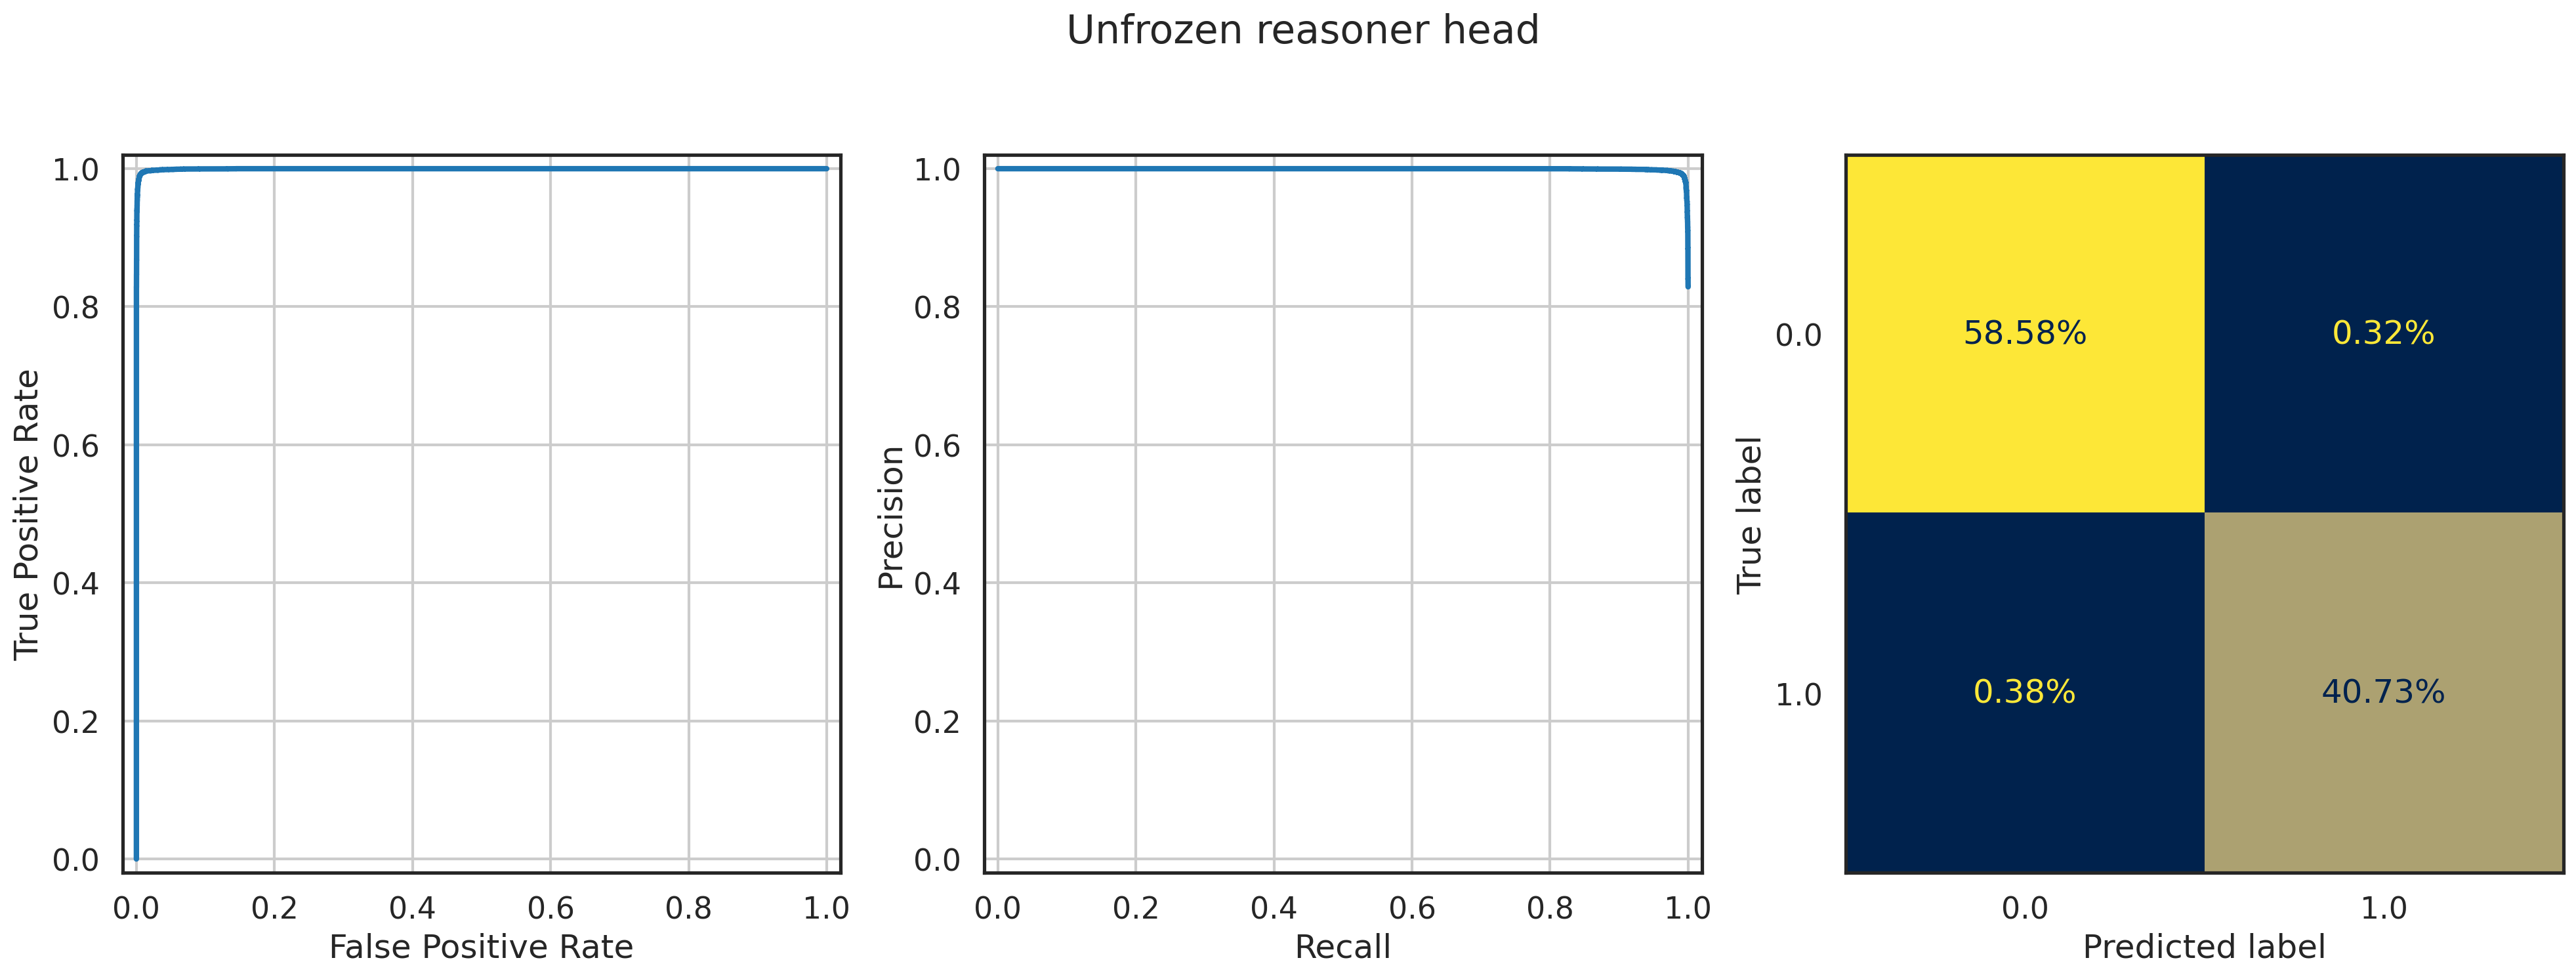

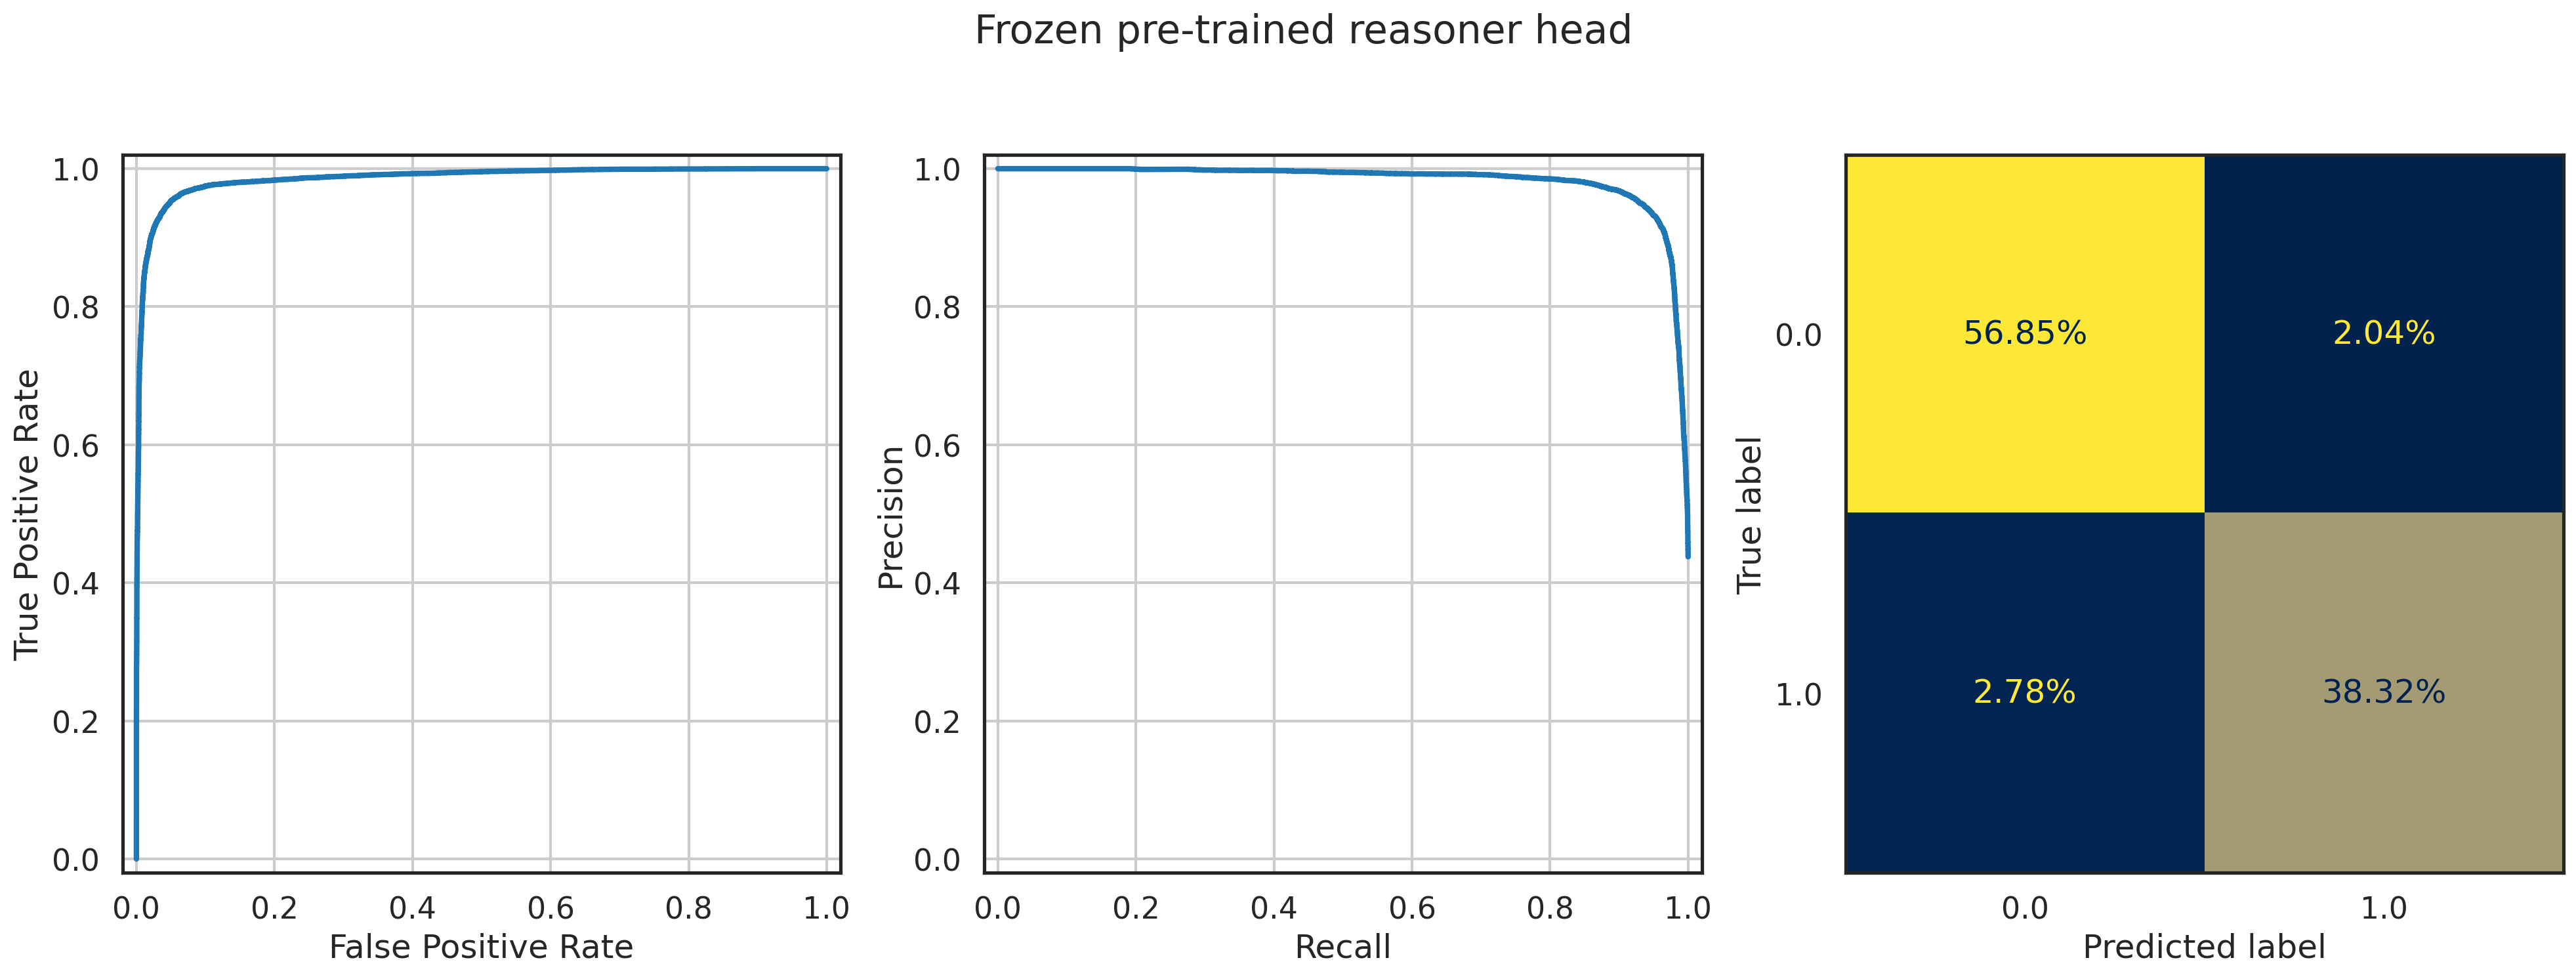

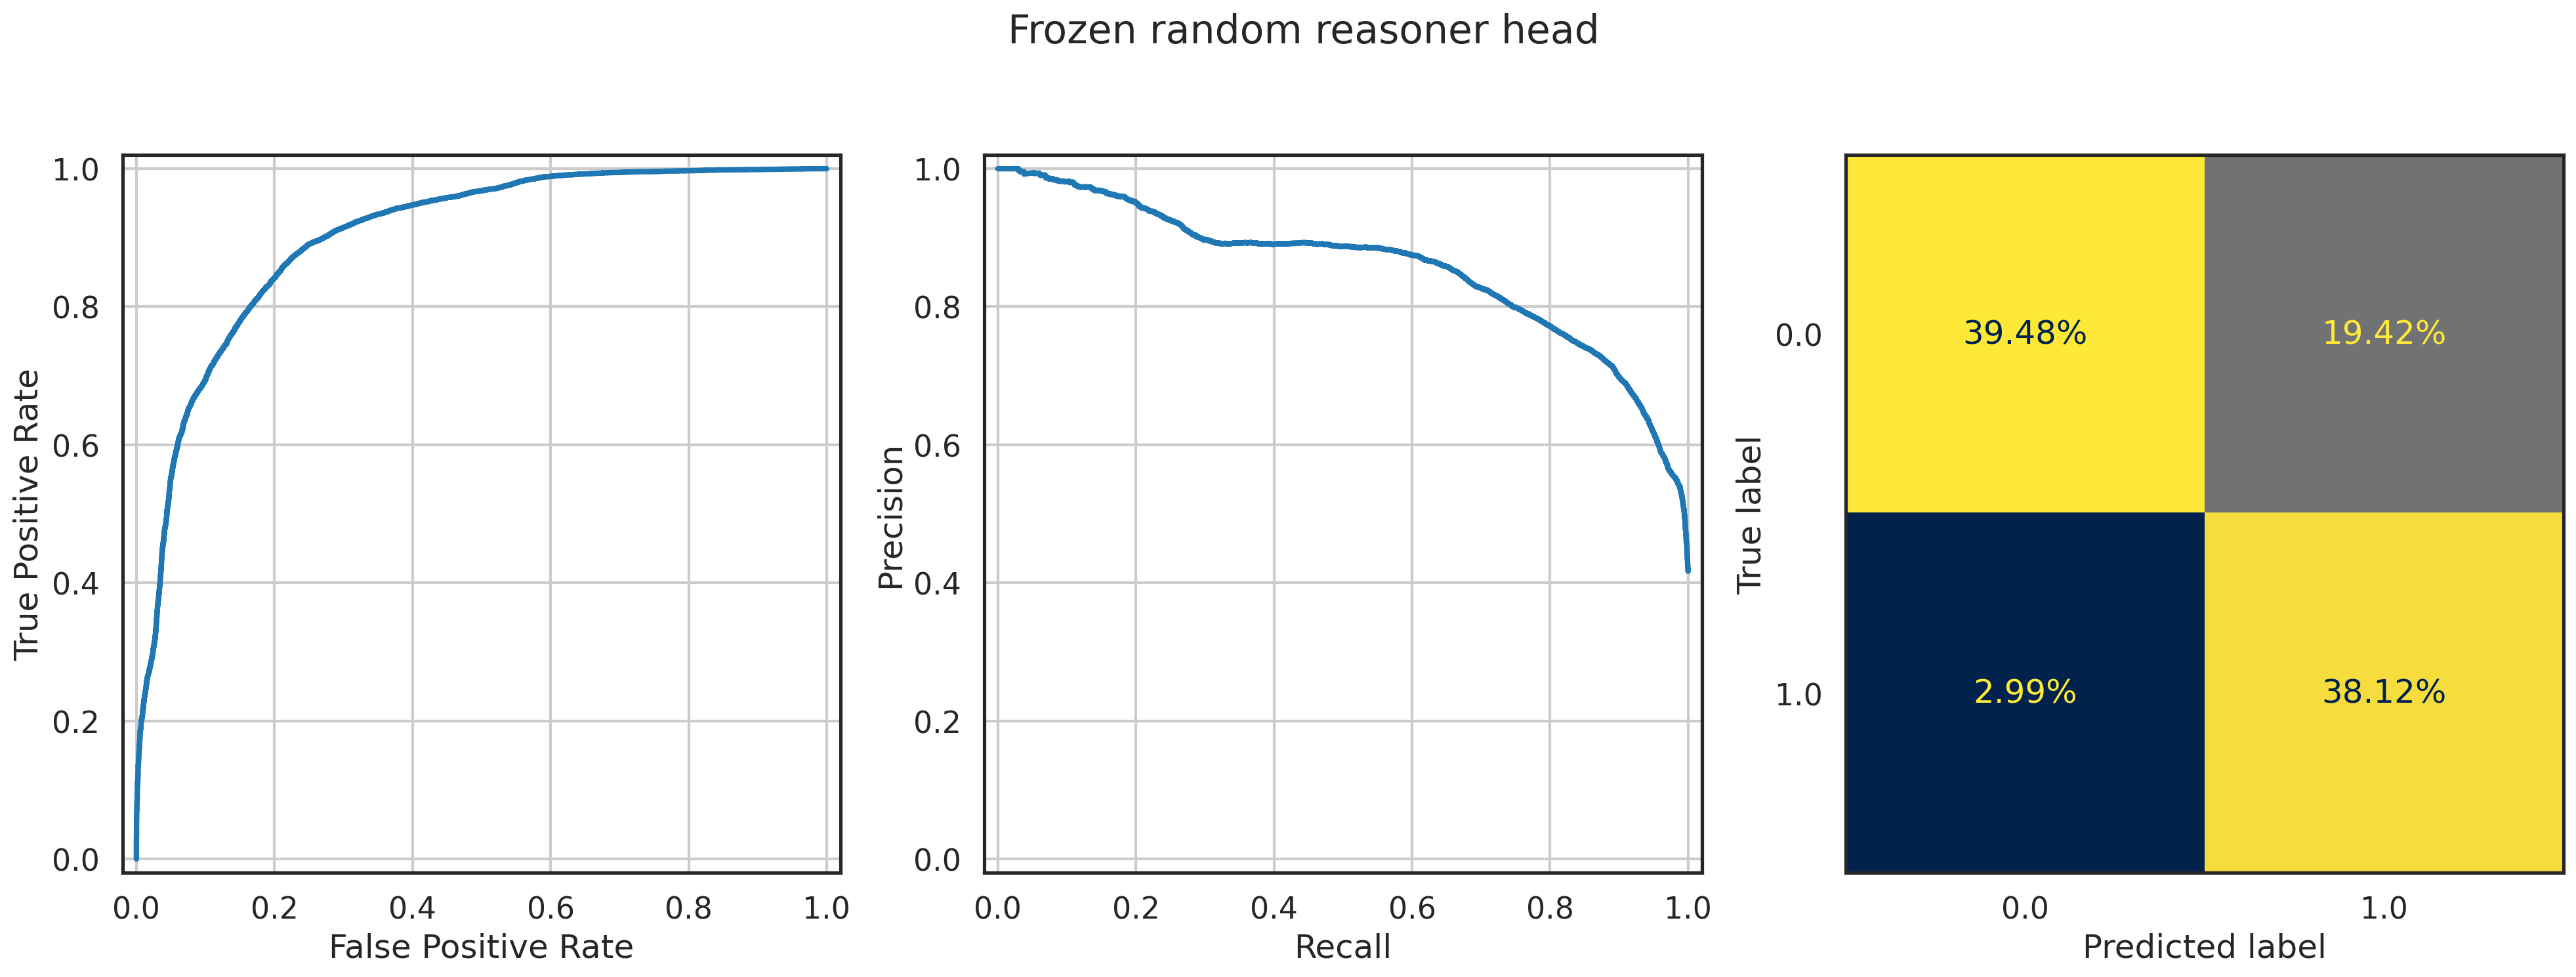

In [6]:
titles = 'Expected', 'Unfrozen reasoner head', 'Frozen pre-trained reasoner head', 'Frozen random reasoner head'
logs = unfrozen_log, transfer_log, random_log
reasoners = unfrozen_r, transfer_r, random_r

for reasoner, log, title in zip(reasoners, logs, titles[1:]):
    print('------')
    with T.no_grad():
        reasoner.eval()
        _, _, Y_te = eval_batch(reasoner.head, [reasoner.embs], X_te, y_te, idx_te)
    print(title)
    print('train time', pd.DataFrame(log.history_tr).groupby('epoch').max().elapsed.sum())
    print(report([onto], y_te, Y_te, idx_te))
    plt.suptitle(title)

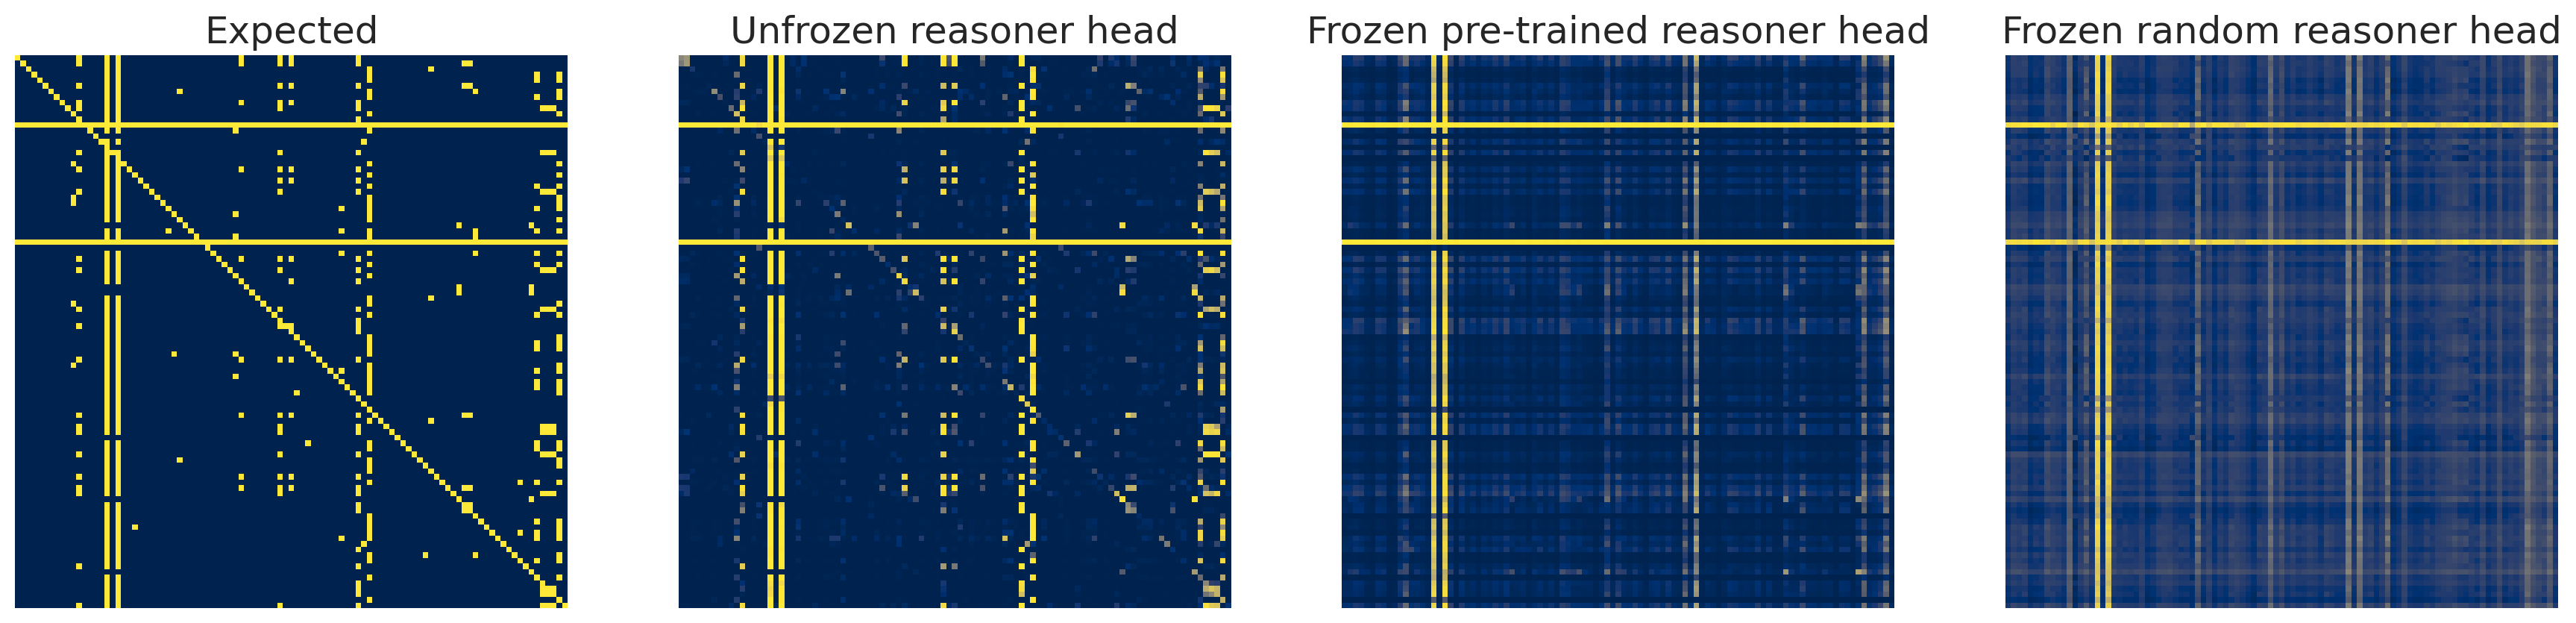

In [7]:
xs = sorted(list(range(onto.n_concepts)), key=lambda i: onto.concepts[i])
ticks = [onto.render(x).replace('Topping', 'T') for x in xs]
n = len(xs)

mats = np.zeros((4, n, n))
for i, c in enumerate(xs):
    for j, d in enumerate(xs):
        mats[0][i][j] = fact.check_sub(c, d)
        mats[1][i][j] = unfrozen_r.check_sub(c, d)
        mats[2][i][j] = transfer_r.check_sub(c, d)
        mats[3][i][j] = random_r.check_sub(c, d)
        
fig, axs = plt.subplots(ncols=4, figsize=(22, 10))
for ax, mat, title in zip(axs, mats, titles):
    sns.heatmap(mat, xticklabels=ticks, yticklabels=ticks, cbar=False, square=True, cmap='cividis', ax=ax)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
plt.grid(True)
plt.show()

2022-07-15 22:43:45.731379: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-15 22:43:45.731405: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


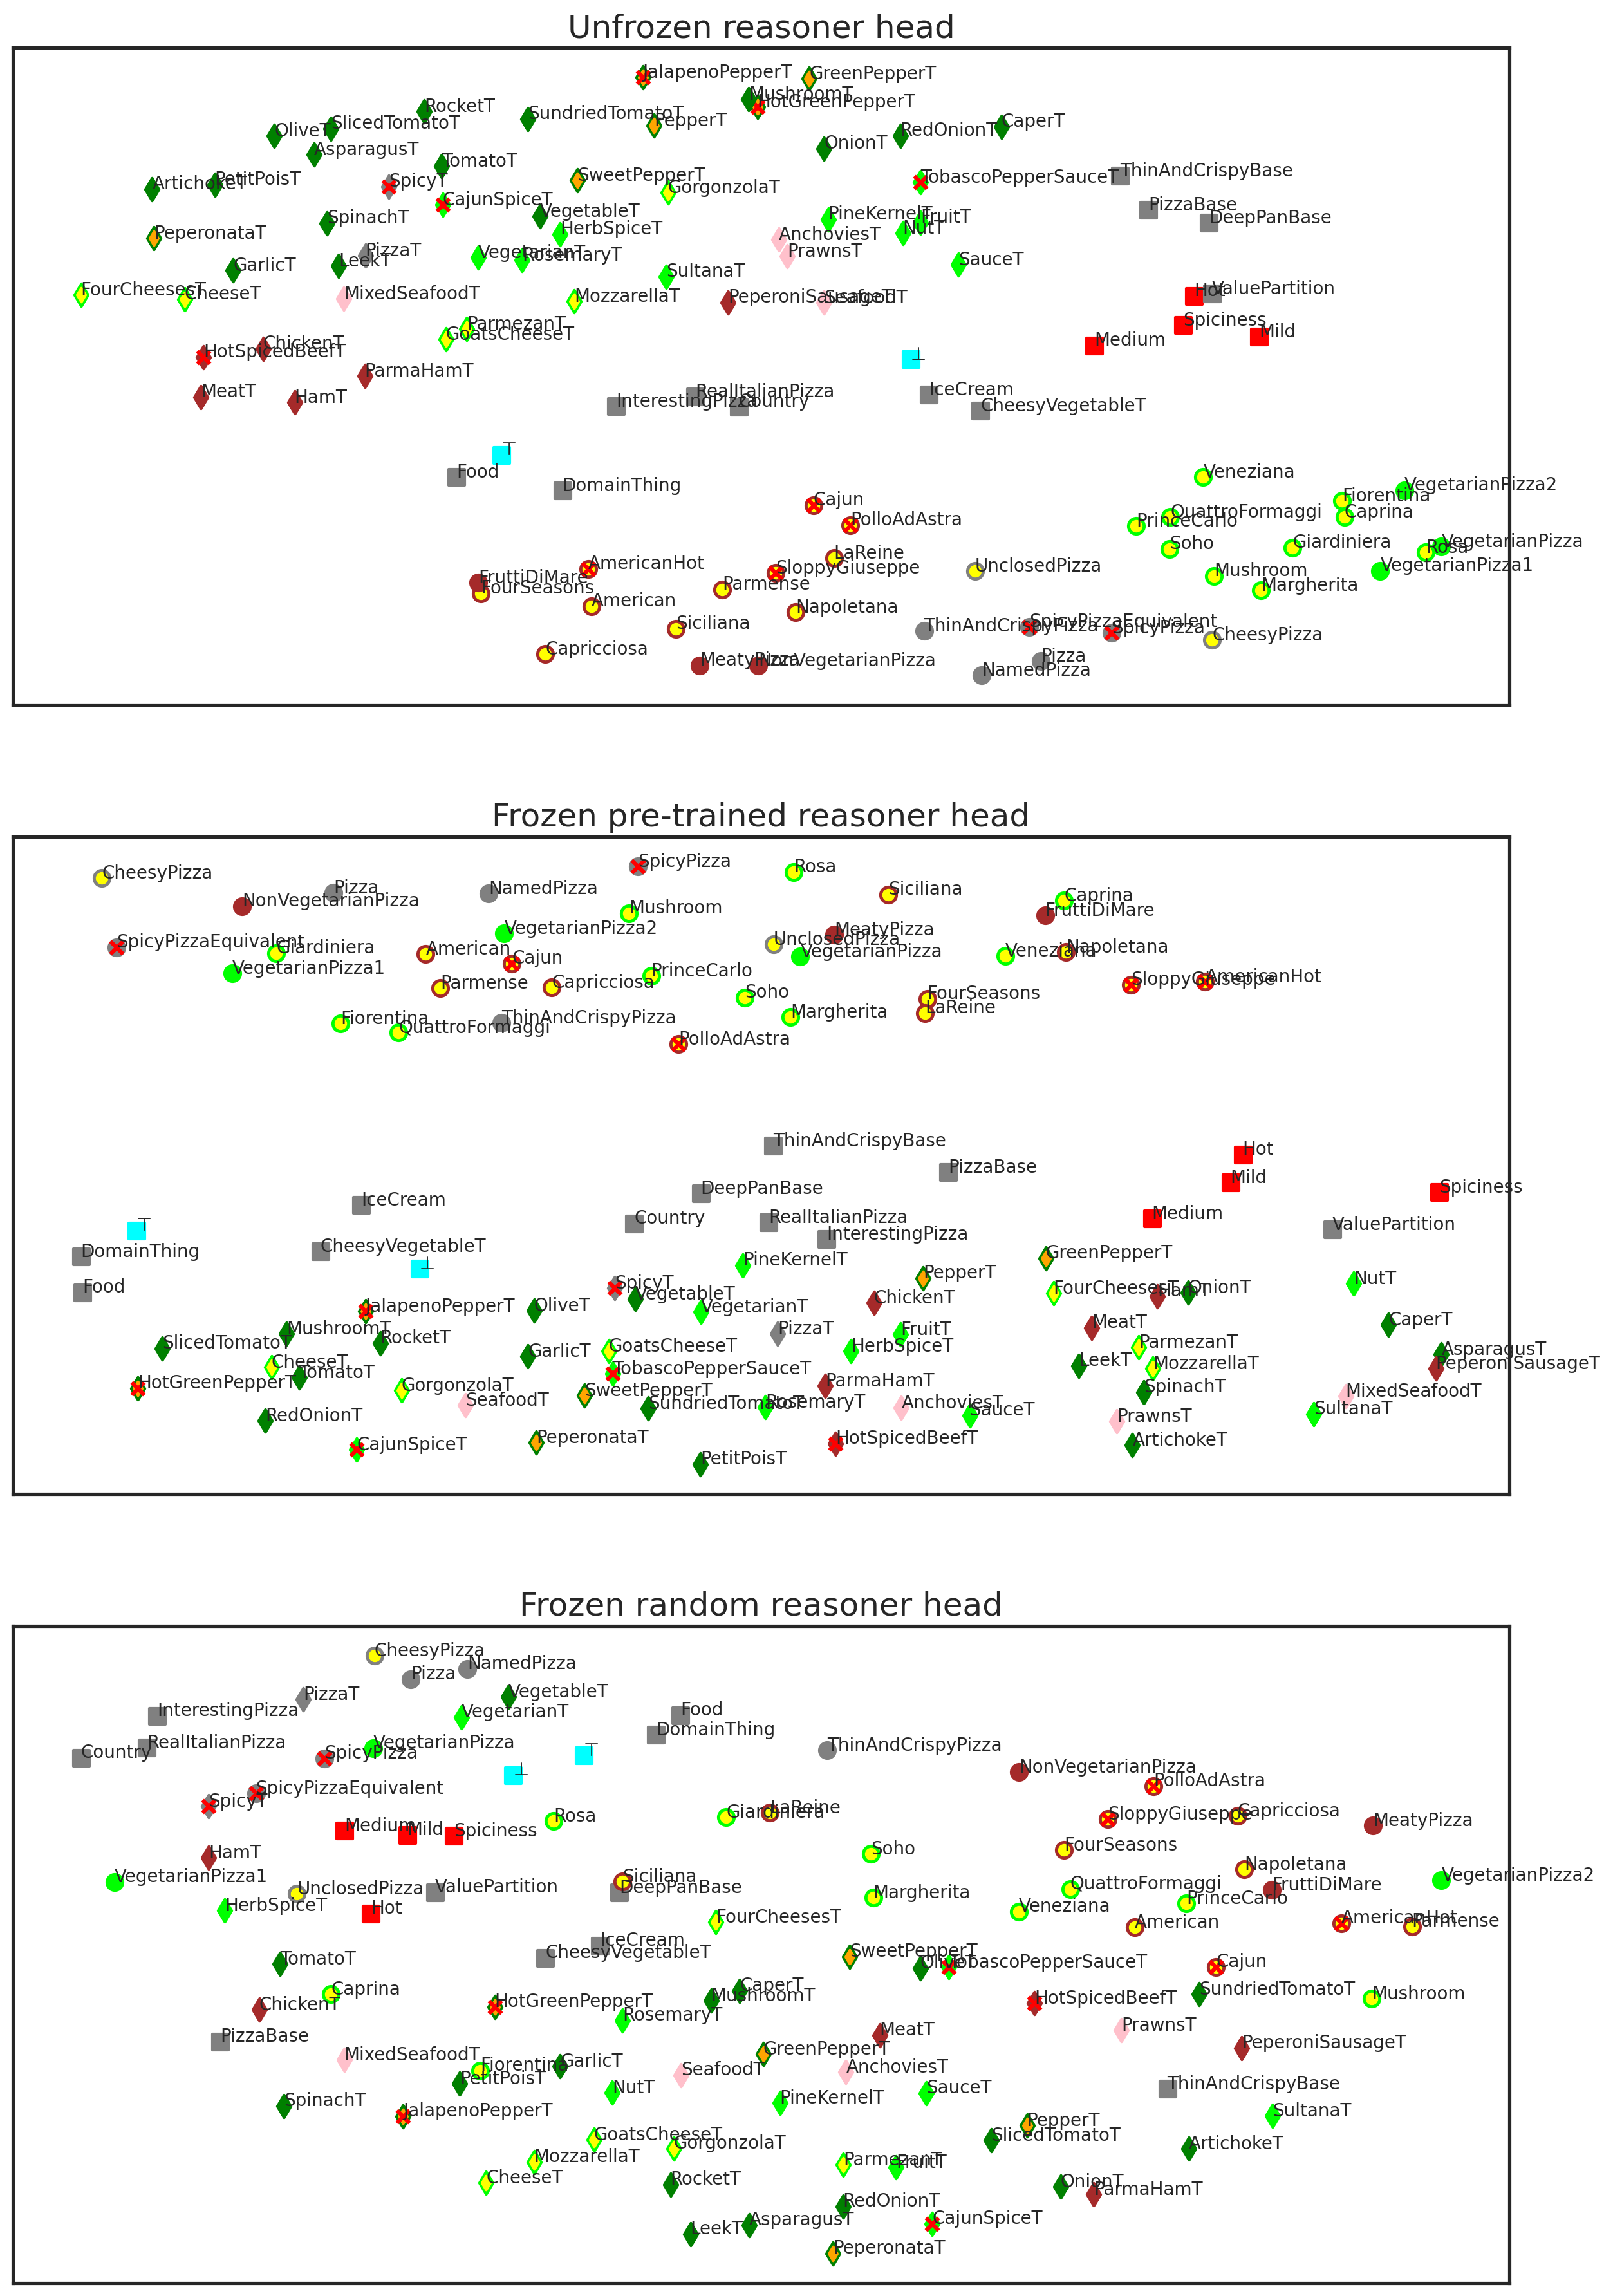

In [8]:
fig, axs = plt.subplots(nrows=3, figsize=(15, 23))
for ax, reasoner, title in zip(axs, reasoners, titles[1:]):
    min_dist = 0.8 if title == 'Frozen pre-trained reasoner head' else 0.3
    vis_pizza(onto, fact, reasoner, min_dist=min_dist, reload_pca=True, seed=seed, ax=ax)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()